# <b>TUTORIAL: Speech to text - Compare models</b>

![title](images/main_sketch.png)

## Introduction

This notebook is the third of a series of tutorials. We strongly recommend you to **read the first episode** [future title] before doing this one, since we will use functions defined and explained in the previous episode. 

## Objective

The different steps of this third tutorial are as follow:
<ul>
    <li>Requirements</li>
    <li>Compare models</li>
</ul>

## Going further
**Next tutorial** will show you how to:

<ul>
    <li>Build a complete Streamlit application to make your code interactive.</li>
</ul>

## Step 1 - Requirements

*This notebook has been created on **AI Notebooks** with the "Miniconda- conda-py39-cuda11.2-v22-4" image.*
### A - Install and import dependencies
As the first step, let's set up the structure of our project. Several librairies need to be installed and imported. 

In [ ]:
!pip install -r requirements.txt

<br>⚠️ After installing these librairies, you may get <b>errors</b> if you try to import them directly. 
<br>To avoid that, just <b>restart the kernel</b> before the imports to make sure everything works fine. (Can be done by clicking the arrow in a circle shape above, or clicking Menu -> Kernel -> Restart kernel) 

In [2]:
# Manipulate sound
import librosa
from pydub import AudioSegment, silence
import audioread

# Load models & metrics to evaluate results
from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration, Wav2Vec2Tokenizer, Wav2Vec2ForCTC, Wav2Vec2Processor, HubertForCTC
import torch
from torchmetrics import WordErrorRate

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd

# Others (Text & time process, system navigation, ...)
import os
import time

### B - Create a folder to temporarily save the sounds we transcribe

In [2]:
dir_path = "/workspace/audio_chunks" 
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

### C - Import code from previous tutorial
All this code has been explained in the first tutorial. 
Only the first function below, named *transcribe_audio_part*, has been reviewed so it can handle different types of models.

In [83]:
def transcribe_audio_part(models_list, results_list, filename, myaudio, sub_start, sub_end, index):
    number_of_models = len(models_list)
    try:
        new_audio = myaudio[sub_start:sub_end]  # Works in milliseconds
        path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".mp3"
        new_audio.export(path)  # Exports to a mp3 file in the current path.
        input_audio, _ = librosa.load(path, sr=16000)

        for model_counter in range (number_of_models):
            start_time = time.time()
            input_values = models_list[model_counter][1](input_audio,
                                         return_tensors="pt").input_values  # Add padding to separate audio, padding="longest", link https://huggingface.co/transformers/v3.0.2/preprocessing.html
                
            logits = models_list[model_counter][0](input_values).logits
            prediction = torch.argmax(logits, dim=-1)
                
            if isinstance(models_list[model_counter][1], Wav2Vec2Tokenizer):
                
                # Decode & add to our caption string
                transcript = models_list[model_counter][1].batch_decode(prediction)[0]

                results_list[model_counter][1] += transcript.lower() + " "
                results_list[model_counter][2] += round(time.time() - start_time, 2)
                
            elif isinstance(models_list[model_counter][1], Wav2Vec2Processor):

                transcript = models_list[model_counter][1].decode(prediction[0])

                results_list[model_counter][1] += transcript.lower() + " "
                results_list[model_counter][2] += round(time.time() - start_time, 2)
                
            else:
                print("Type not recognized: ", type(processor_or_tokenizer)) 
    
    except audioread.NoBackendError:
        # Means we have a chunk with a [value1 : value2] case with value1>value2
        print("Sorry, seems we have a problem on our side. Please change start & end values.")
        
        # Stop 
        exit()

In [3]:
def detect_silences(audio):
    # Get Decibels (dB) relative to Full Scale so silence detections depends on the audio instead of a fixed value
    dbfs = audio.dBFS
    
    # Get silences timestamps > 750ms 
    silence_list = silence.detect_silence(audio, min_silence_len=750, silence_thresh=dbfs-14)
    return silence_list

In [4]:
def get_middle_values(silence_list):
    # Replace timestamps by their middle value
    new_silence_list=[]
    for timestamp in silence_list:
        new_silence_list.append(timestamp[0]+(timestamp[1]-timestamp[0])/2)
    return new_silence_list

In [5]:
def silences_distribution(silence_list, min_space, max_space, start, end, srt_token = False):
    """
    We keep each silence value if it is sufficiently distant from its neighboring values, without being too much
    :param silence_list: List with silence intervals
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :param start: int value (s) given by st.slider() (fixed by user)
    :param end: int value (s) given by st.slider() (fixed by user)
    :param srt_token: Enable/Disable generate srt file (choice fixed by user)
    :return: list with equally distributed silences
    """
    end -= start
    start = 0
    end *= 1000
    
    # Adding first element
    newsilence = [silence_list[0]]
    min_desired_value = silence_list[0]
    max_desired_value = silence_list[0]
    nb_values = len(silence_list)-1  # Minus one bc we have added the first element, so there is one less

    # end - newsilence[-1] > min_space
    while nb_values != 0:
        max_desired_value += max_space
        silence_window = list(filter(lambda x: min_desired_value < x <= max_desired_value, silence_list))
        if silence_window != []:
            if srt_token:
                nearest_value = min(silence_window, key=lambda x: abs(x - min_desired_value))  # 10 = 20/2
                nb_values -= silence_window.index(nearest_value) + 1  # (begins at 0, so we add 1)
            else:
                nearest_value = min(silence_window, key=lambda x: abs(x - max_desired_value))  # 10 = 20/2
                # Max value index = len of the list
                nb_values -= len(silence_window)

            if nearest_value - newsilence[-1] <= min_space:
                # If we have near values, we change the last value to the new one
                # But we need to check with the two values before if gap is > max_space (mustn't)
                if len(newsilence) >= 2:
                    if nearest_value - newsilence[-2] > max_space:
                        # Gap Too important
                        newsilence.append(nearest_value)
                    else:
                        newsilence[-1] = nearest_value
                else:
                    # There is only one value for now, we can modify it
                    newsilence.append(nearest_value)
            else:
                # If gap > min_space
                newsilence.append(nearest_value)

        else:
            newsilence.append(newsilence[-1] + max_space)  # We add the max_space to avoid multiple audio cutting

        min_desired_value = newsilence[-1]
        max_desired_value = newsilence[-1]

    final_value = end
    if final_value - newsilence[-1] > min_space:
        # Gap > Min Space
        if final_value - newsilence[-1] < max_space:
            newsilence.append(final_value)
        else:
            # Gap too important => Automatic max_space cut till the end
            newsilence = generate_regular_split(newsilence, int(end), min_space, max_space)
    else:
        # Gap < Min Space <=> Final value and last value of new silence are too close
        if len(newsilence) >= 2:
            if final_value - newsilence[-2] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = final_value
            else:
                newsilence.append(final_value)

        else:
            if final_value - newsilence[-1] <= max_space:
                # Replace if gap is not too important
                newsilence[-1] = final_value
            else:
                newsilence.append(final_value)

    if len(newsilence) >= 2:
        # Replace or Adding start
        if newsilence[0] - start < max_space:
            # Replace to avoid a transcription from 0 to 0.9s (first silence)
            newsilence[0] = start
        else:
            #Adding
            newsilence.insert(0, start)
    else:
        newsilence.insert(0, start)

    return newsilence

In [6]:
def generate_regular_split(time_list, end, min_space, max_space):
    """
    Add automatic "time cuts" to mylist till end value depending on min_space and max_space value
    :param time_list: silence time list
    :param end: int value (s) given by st.slider() (fixed by user)
    :param min_space: Minimum temporal distance between two silences
    :param max_space: Maximum temporal distance between two silences
    :return: list with automatic time cuts
    """
    for i in range(int(time_list[-1]), end, max_space):
        value = i + max_space
        if value < end:
            time_list.append(value)

    # Fixing last automatic cut
    # Small Gap (395 000, with end = 400 000)
    if end - time_list[-1] < min_space:
        time_list[-1] = end
    else:
        # Important gap ( 311 000 then 356 000, with end = 400 000, can't have 311k to 400k)
        time_list.append(end)
    return time_list

## Step 2: Load Pretrained models
This time, we are not going to only import the base 960h Wav2Vec2 model. 

*Base 960h* version, available on __[Hugging Face website](https://huggingface.co/models)__, is the most popular one. 

But we can ask ourselves if that means this is the best one? The fastest? And the most qualitative? 
<br>To answer this question, we are going to load different models from Hugging Face. Then, we will use each of them to transcribe same audio files and we will compare the results thanks to WER metric, seen in first tutorial. 

https://paperswithcode.com/sota/automatic-speech-recognition-on-librispeech-2

<br>⚠️ Messages in red as below may appear throughout the execution of the code.
<br>Do not worry, these warnings are generated by the libraries and do not disturb the execution of the code.

### Create a list to save models and results
<blockquote>Each model will be saved in a list</blockquote>

In [7]:
results_list = []
models_list = []

### Load Base 960h Wav2Vec2
Rank (Number of downloads): #1
<br>Train: 960 hours of Librispeech

In [8]:
model_name = "facebook/wav2vec2-base-960h"
model = Wav2Vec2ForCTC.from_pretrained(model_name)
tokenizer = Wav2Vec2Tokenizer.from_pretrained(model_name)

# Add model to list
if [model, tokenizer] not in models_list:
    models_list.append([model, tokenizer])
    results_list.append([model_name, "", 0])

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/workspace/.miniconda3/lib/python3.9/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:750: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


### Load hubert large ls960 fine tuned Model
Rank (Number of downloads): #2
<br>Train: 960 hours of Librispeech

In [9]:
model_name = "facebook/hubert-large-ls960-ft"
model = HubertForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    results_list.append([model_name, "", 0])

### Load Large 960h Wav2Vec2
Rank (Number of downloads): #3
<br>Train: 960 hours of Librispeech

In [10]:
model_name = "facebook/wav2vec2-large-960h"
model = Wav2Vec2ForCTC.from_pretrained(model_name) #.to("cuda")
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    results_list.append([model_name, "", 0])

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load Large 960h Lv60 Wav2Vec2 + Self-Training 
Rank (Number of downloads): #6
<br>Train: 960 hours of Libri-Light and Librispeech

In [11]:
model_name = "facebook/wav2vec2-large-960h-lv60-self"
model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    results_list.append([model_name, "", 0])

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load Large robust Wav2Vec2
Rank (Number of downloads): #3400
<br> Pretrained on
    Libri-Light: open-source audio books from the LibriVox project; clean, read-out audio data
    CommonVoice: crowd-source collected audio data; read-out text snippets
    Switchboard: telephone speech corpus; noisy telephone data
    Fisher: conversational telephone speech; noisy telephone data

and finetuned on 960 hours of Librispeech: open-source read-out audio data.


In [12]:
model_name = "facebook/wav2vec2-large-robust-ft-libri-960h"

model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    results_list.append([model_name, "", 0])

### Large 960 lvl 60 Wav2Vec2
Rank (Number of downloads): #436
Train : pretrained and fine-tuned on 960 hours of Libri-Light and Librispeech

In [13]:
model_name = "facebook/wav2vec2-large-960h-lv60"

model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    results_list.append([model_name, "", 0])

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Base 100h Wav2Vec2
Rank (Number of downloads): #2839
<br>Train : Not known

In [14]:
model_name = "patrickvonplaten/wav2vec2-base-100h-with-lm"

model = Wav2Vec2ForCTC.from_pretrained(model_name)
processor = Wav2Vec2Processor.from_pretrained(model_name)

# Add model to list
if [model, processor] not in models_list:
    models_list.append([model, processor])
    results_list.append([model_name, "", 0])

## Step 2 - Transcribe some audios 

Now we will use the loaded models to transcribe text. Two metrics will be taken here, **execution time** and **word error rate** (WER).

First, let's try with Obama's speech with silence method detection!

### Load Obama's speech

In [29]:
obama_audio = AudioSegment.from_file("/workspace/Speech_to_Text/sounds/obama.mp3")

# detect silences and silences treatment
silence_list = detect_silences(obama_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=obama_audio.duration_seconds)

### Transcribe audio file

In [31]:
# transcribe
transcript = ""
for i in range(0, len(silence_list) - 1):
    sub_start = silence_list[i]
    sub_end = silence_list[i + 1]
    
    # Initial audio has been split with start & end values
    # It begins to 0s, but the timestamps need to be adjust with +start*1000 values to adapt the gap
    
    transcribe_audio_part(models_list, results_list, "obama.mp3", obama_audio, sub_start, sub_end, i)

NameError: name 'transcribe_audio_part' is not defined

### Display results in a DataFrame

In [20]:
df=pd.DataFrame(data = results_list, columns=['Model', 'Transcript', 'Execution time'])
display(df)

,Model,Transcript,Execution time
0,facebook/wav2vec2-base-960h,for even as we celebrate to night we know that...,8.58
1,facebook/hubert-large-ls960-ft,for even as we celebrate to night we know that...,21.38
2,facebook/wav2vec2-large-960h,for even as we celebrate to night we know the ...,20.61
3,facebook/wav2vec2-large-960h-lv60-self,for even as we celebrate to night we know the ...,20.33
4,facebook/wav2vec2-large-robust-ft-libri-960h,for even as we celebrate to night we know the ...,21.74
5,facebook/wav2vec2-large-960h-lv60,for even as we celebrate to night we know the ...,20.52
6,patrickvonplaten/wav2vec2-base-100h-with-lm,for even as we celebrate to night we know the ...,5.62


### Calculate and add transcript’s WER to the DataFrame

As we saw in the first episode, WER measures the quality of the transcript. If we compare each WER, we can try to identify the best performing model.

As WER counts errors, the lower its value, the better the transcript. 

In [21]:
# Real transcript
real_text = """for even as we celebrate tonight we know the challenges that tomorrow will bring are the greatest of our lifetime i stand here knowing that my story is part of the larger american story that i owe a debt to all of those who came before me and that in no other country on earth is my story even possible i'm the son of a black man from kenya and a white woman from kansas i am married to a black american who carries within her the blood of slaves and slave owners i have brothers sisters nieces nephews uncles and cousins of every race and every hue scattered across three continents these people are part of me and they are part of america this country that i love i've come here to cairo to seek a new beginning between the united states and muslims around the world one based on mutual interest and mutual respect just as muslims do not fit a crude stereotype america is not the crude stereotype of a self-interested empire to say that force may sometimes be necessary is not a call to cynicism it is a recognition of history the imperfections of man and the limits of reason we gather here to honor the courage of ordinary americans willing to endure billy clubs and the chastening rod tear gas and the trampling hoof men and women who despite the gush of blood and splintered bone would stay true to their north star and keep marching towards justice blinded by hatred the alleged killer could not see the grace surrounding reverend pinckney and that bible study group the light of love that shone as they opened the church doors and invited a stranger to join in their prayer circle the alleged killer could have never anticipated the way the families of the fallen would respond when they saw him in court in the midst of unspeakable grief with words of forgiveness he could not imagine that and while this nation has been tested by war and it's been tested by recession and all manner of challenges i stand before you again tonight after almost two terms as your president to tell you i am more optimistic about the future of america than ever before hey nbc news fans thanks for checking out our youtube channel subscribe by clicking on that button down here and click on any of the videos over here to watch the latest interviews show highlights and digital exclusives thanks for watching """

In [26]:
# Load metric
metric = WordErrorRate()

# Calculate and save all WER score in a list
wer_score = []
for elt in results_list:
    wer_score.append(round(metric(elt[1], real_text).item()*100, 2))

In [27]:
# Add WER as a new column to the DataFrame
df_with_wer = df.assign(WER=wer_score)

In [45]:
# Display new DataFrame
display(df_with_wer)

,Model,Transcript,Execution time,WER
1,facebook/hubert-large-ls960-ft,for even as we celebrate to night we know that...,21.38,7.14
3,facebook/wav2vec2-large-960h-lv60-self,for even as we celebrate to night we know the ...,20.33,7.86
4,facebook/wav2vec2-large-robust-ft-libri-960h,for even as we celebrate to night we know the ...,21.74,8.10
5,facebook/wav2vec2-large-960h-lv60,for even as we celebrate to night we know the ...,20.52,8.10
2,facebook/wav2vec2-large-960h,for even as we celebrate to night we know the ...,20.61,12.62
0,facebook/wav2vec2-base-960h,for even as we celebrate to night we know that...,8.58,14.76
6,patrickvonplaten/wav2vec2-base-100h-with-lm,for even as we celebrate to night we know the ...,5.62,20.95


### Sort DataFrame by WER 
Keep in mind that the lower WER, the better the transcript!

In [ ]:
df_with_wer = df_with_wer.sort_values(by=['WER']) 
display(df_with_wer)

⚠️ Execution time here only measures the speed of transcribing action and does not take into account other elements like the loading time of each audio chunk. 

The considered audio is approximatively 3 minutes long. With this duration alone, we already notice big differences in terms of execution time and WER. 
Indeed, the fastest model finishes transcribing the file in 5 seconds, while the longest one does it in four times more time. However, we notice that its WER is three times lower than the longest model.

From this observation, we can deduce that the longer the model takes, the more satisfactory the resulting transcription will be.

The question we now ask ourselves is which is the best model in terms of time/WER ratio. Indeed, we notice that the best model here, *facebook/hubert-large-ls960-ft* has a better WER than the second one, but takes more time. 

Is this slight difference worth it? 
And is the first model here really the best model among the list? It is necessary to make a maximum of tests on different audios to draw any conclusion!

### Optionnal: Compare

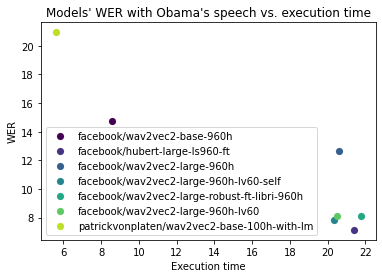

In [46]:
fig, ax = plt.subplots()

colormap = cm.viridis
colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 0.9, len(df_with_wer['Model']))]

for i,c in enumerate(colorlist):

    x = df_with_wer['Execution time'][i]
    y = df_with_wer['WER'][i]
    l = df_with_wer['Model'][i]

    ax.scatter(x, y, label=l, s=50, linewidth=0.1, c=c)

ax.legend()

plt.title("Models' WER with Obama's speech vs. execution time")
plt.xlabel("Execution time")
plt.ylabel("WER")
plt.show()

In [15]:
oral_comp_audio = AudioSegment.from_file("/workspace/Speech_to_Text/sounds/oral_comprehension-Tiny_homes_for_the_homeless.mp3")

# detect silences and silences treatment
silence_list = detect_silences(oral_comp_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=oral_comp_audio.duration_seconds)

In [37]:
create_audio_chunks("/workspace/audio_chunks/", "oral_comprehension-Tiny_homes_for_the_homeless.mp3", oral_comp_audio)

In [93]:
def transcribe_audio_partv3(models_list, results_list, filename, myaudio, sub_start, sub_end, index):
    number_of_models = len(models_list)
    index = 0 
    try:
        new_audio = myaudio[sub_start:sub_end]  # Works in milliseconds
        path = "/workspace/audio_chunks/" + filename[:-3] + str(index) + ".mp3"
        new_audio.export(path)  # Exports to a mp3 file in the current path.
        input_audio, _ = librosa.load(path, sr=16000)

        while number_of_models != 0:
            models = models_list.pop(0)
            
            start_time = time.time()
            input_values = models[1](input_audio,
                                         return_tensors="pt").input_values  # Add padding to separate audio, padding="longest", link https://huggingface.co/transformers/v3.0.2/preprocessing.html
                
            logits = models[0](input_values).logits
            prediction = torch.argmax(logits, dim=-1)
                
            if isinstance(models[1], Wav2Vec2Tokenizer):
                
                # Decode & add to our caption string
                transcript = models[1].batch_decode(prediction)[0]

                results_list[index][1] += transcript.lower() + " "
                results_list[index][2] += round(time.time() - start_time, 2)
                
            elif isinstance(models[1], Wav2Vec2Processor):

                transcript = models[1].decode(prediction[0])

                results_list[index][1] += transcript.lower() + " "
                results_list[index][2] += round(time.time() - start_time, 2)
                
            else:
                print("Type not recognized: ", type(processor_or_tokenizer)) 
            index += 1
            
    except audioread.NoBackendError:
        # Means we have a chunk with a [value1 : value2] case with value1>value2
        print("Sorry, seems we have a problem on our side. Please change start & end values.")
        
        # Stop 
        exit()

In [50]:
# Test try to don't make kernel die

models_listcopy = models_list.copy()
number_of_models = len(results_list)
transcript = ""
chunks_directory = "/workspace/audio_chunks/"
index=0 
while len(models_listcopy) != 0:
    models = models_listcopy.pop(0)
    
    for filename in os.listdir(chunks_directory):
        f = os.path.join(chunks_directory, filename)
        
        # checking if it is a file
        if os.path.isfile(f):
            input_audio, _ = librosa.load(f, sr=16000)
            
            start_time = time.time()

            input_values = models[1](input_audio,
                                        return_tensors="pt").input_values  # Add padding to separate audio, padding="longest", link https://huggingface.co/transformers/v3.0.2/preprocessing.html

            logits = models[0](input_values).logits
            prediction = torch.argmax(logits, dim=-1)
                
            if isinstance(models[1], Wav2Vec2Tokenizer):

                # Decode & add to our caption string
                transcript = models[1].batch_decode(prediction)[0]
                print(transcript)
                results_list[index][1] += transcript.lower() + " "
                results_list[index][2] += round(time.time() - start_time, 2)

            elif isinstance(models[1], Wav2Vec2Processor):

                transcript = models[1].decode(prediction[0])
                print(transcript)
                results_list[index][1] += transcript.lower() + " "
                results_list[index][2] += round(time.time() - start_time, 2)

            else:
                print("Type not recognized: ", type(processor_or_tokenizer)) 
                
    index += 1

/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BEING A CRIMINAL ONE MONTH AGO AMANDA MC DUGALD WAS LIVING ON THE STREETS THAT NIGHT I WAS IN A HOUSE HAD A HOUSE A ROOF OVER MY HEAD SO IT'S A HUGE BLESSING TO DAY SHE HAS HER OWN HOME NEAR THIRTY EIGHTH IN WALNUT AND SAYS IT'S A STEP UP FROM LIVING IN A SHELTER I HAVE ENSOMNIA IN PISYESTI AN II'VE IVE HIGH ANXIETY AND I DON'T DO WELL WITH WITH THE SHELTER LIFE FOR THAT REASON AND ALSO BECAUSE I'M I I'M SOBER MYSELF AND YOU'RE AROUND A LOT OF DRUGG USERS AND A STUFF LIKE THAT IN A SHELTER AND IT'S JIS NOT CONDUCIVE TO STAYING SOBER BELOVED COMMUNITY VILLAGE HOUSES THIRTEEN OF DUNBER'S HOMELIST IN ELEVEN TINY HOMES COMPLETE WITH A LIBRARY UWE HAVE NEW ONES NOW AND COMMUNITY GARDEN SO WE HAVE A NICE UGE


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


OCANY THERE AND


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


OHOMADIVERS HOMELESS NOW HAVE A SAFE PLACE TO CALL HOME THEY ARE LIVING IN TINY HOMES WHAT WE'VE BEEN REPORTING ON THESE UNITS SINCE CONSTRUCTION BEGAN EARLIER THIS YEAR THEY'RE THIRTY EIGHTH AN WALNUT RIGHT IN THE RINO DISTRICT ANDREA FLORAS HAS BEEN FOLLOWING THE PROGRESS OF THESE TINY HOMESFOREST ANDREA LOOKS LIKE PEOPLE AR STARTING TO SETTLE IN WELL THEY CERTAINLY ARE THE APPLICATION PROCESS BEGAN MONTHS AGO AND THE REQUIREMENTS WERE A SIMPLE HOMELESSNESS NO ILLEGAL DRUG USE AND NO VIOLENCE THIRTEEN PEOPLE WERE PICKED TO LIVE IN THESE TINY HOMES AND RESIDENTS TELL ME THEY SAY THIS IS THE PERFECT WAY TO GET A TASTE OF WHAT IT COULD BE LIKE TO LIVE ON THEIR OWN THAT MORNING I HAD GOTTEN WOKEN UP BY COBS IM AS IF I WAS


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BEING A CRIMINAL ONE MONTH AGO A MANDE MC DUGULD WAS LIVING ON THE STREETS THAT NIGHT I WAS IN A HOUSE HAD A HOUSE OF ROOF OVER MY HEAD SO IT'S A HUGE BLESSING TO DAY SHE HAS HER OWN HOME NEAR THIRTY EIGHTH IN WALNUT AND SAYS IT'S A STEP UP FROM LIVING IN A SHELTER I HAVEN'T SOMNA IN PICIESTI AND I IVE HIGH ANXIETY AND I DON'T DO WELL WITH WITH THE SHELTER LIFE FOR THAT REASON AND ALSO BECAUSE M IMI'M SOBER MYSELF AND YOU'RE AROUND A LOT OF JUGGISERS AND IT'S TUFF LIKE THAT IN A SHELTER AND IT'S JUST NOT CONDUCIVE TO STAINGS OVER BELOVED COMMUNITY VILLAGE HOUSES THIRTEEN OF DUNBER'S HOMELETS IN ELEVEN TINY HOMES COMPLETE WITH A LIBRARY BUT WE HAVE NEW ONES NOW AND COMMUNITY GARDEN WE HAVE A NICE HEAR


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


E PLAY ME THERE AND


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


MADIVER'S HOME LUS NOW HAVE A SAFE PLACE TO CALL HOME THEY ARE LIVING IN TINY HOMES WERE WE'VE BEEN REPORTING ON THESE UNITS SINCE CONSTRUCTION BEGAN EARLIER THIS YEAR THERE ARE THIRTY EIGHTH ON WALNUT RIGHT IN THE RINO DISTRICT ANDREA FLORIS HAS BEEN FOLLOWING THE PROGRESS OF THESE TINY HOMES FORST ANDREA LOOKS LIKE PEOPLE ARE STARTING TO SETTLE IT WHILE THEY CERTAIN LYARE THE APPLICATION PROCESS BEGAN A MONTHS AGO IN THE REQUIREMENTS WER SIMPLE HOMELESSNESS NO ILEGAL DRUG USE AND NO VIOLENCE THIRTEEN PEOPLE WERE PICKED TO LIVE IN THESE TINY HOMES AN RESIDENCE TELL ME THEY SAY THIS IS THE PERFECT WAY TO GET A TASTE OF WHAT IT COULD BE LIKE TO LIVE ON THEIR OWN THAT MORNING I HAD GOTTEN WOKEN UT BY COBS UM AS IF I WAS


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BEING A CRIMINAL ONE MONTH AGO AMANDA MCDOUGALD WAS LIVING ON THE STREET THAT NIGHT I WAS IN A HOUSE HAD A HOUSE A ROOF OVER MY HEAD SO IT'S A HUGE BLESSING TO DAY SHE HAS HER OWN HOME NEAR THIRTY EIGHTH IN WALNUT AND SAYS IT'S A STEP UP FROM LIVING IN A SHELTER I HAVEN'T SOME AN PIECE YESY AND I I HIGH ANXIETY AND I DON'T DO WELL WITH WITH THE SHELTER LIFE FOR THAT REASON AND ALSO BECAUSE I'M SOBER MYSELF AND YOU'RE AROUND A LOT OF JRUGGESERS AND AN STUFF LIKE THAT IN A SHELTER AND ITS DOS NOT CONDUCIVE TO STAYING SOBER BELOVED COMMUNITY VILLAGE HOUSES THIRTEEN OF DUNBER'S HOMELESS IN ELEVEN TINY HOMES COMPLETE WITH A LIBRARY WE HAVE NEW ONES NOW AND COMMUNITY GARDEN WE HAVE A NICE ER


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


TAN ME THERE


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


MADIVERS HOMELESS NOW HAVE A SAFE PLACE TO CALL HOME THEY ARE LIVING IN TINY HOMES WHAT WE'VE BEEN REPORTING ON THESE UNITS SINCE CONSTRUCTION BEGAN EARLIER THIS YEAR THERE RE THIRTY EIGHTH AND WALNUT RIGHT IN THE RINO DISTRICT ANDREA FLORES HAS BEEN FOLLOWING THE PROGRESS OF THESE TINY HOMES FOR US ANDREA LOOKS LIKE PEOPLER STARTING TO SETTLE IN WELL THEY CERTAINLY ARE THE APPLICATION PROCESS BEGAN MONTHS AGO AND THE REQUIREMENTS WERE SIMPLE HOMELESSNESS NO ILLEGAL DRUG USE AND NO VIOLENCE THIRTEEN PEOPLE WERE PICKED TO LIVE IN THESE TINY HOMES AND RESIDENTS TELL ME THEY SAY THIS IS THE PERFECT WAY TO GET A TASTE OF WHAT IT COULD BE LIKE TO LIVE ON THEIR OWN THAT MORNING I HAD GOTTEN WOKEN UP BY COUGHS AS IF I WAS


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BEING A CRIMINAL ONE MONTH AGO AMANDA MC DUGLD WAS LIVING ON THE STREETS THAT NIGHT I WAS IN A HOUSE HAD A HOUSE A ROOF OVER MY HEAD SO IT'S A HUGE BLESSING TO DAY SHE HAS HER OWN HOME NEAR THIRTY EIGHTH IN WALNUT AND SAYS IT'S A STEP UP FROM LIVING IN A SHELTER I HAVET SO MANIN PECESTY AND IIV I HIGH ANXIETY AND I DON'T DO WELL WITH WITH THE SHELTER LIFE FOR THAT REASON AND ALSO BECAUSE I'M IM I'M SOBER MYSELF AND YOU'RE AROUND A LOT OF DRUG USERS AND AND STUFF LIKE THAT AN A SHELTER AND IT'S JUST NOT CONDUCIVE TO STAYING SOBER BELOVED COMMUNITY VILLAGE HOUSES THIRTEEN OF DUNBER'S HOMELIST IN ELEVEN TINY HOMES COMPLETE WITH A LIBRARY WE HAVE NEW ONES NOW AND COMMUNITY GARDEN WE HAVE A NICE HER


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


SU CANY THERE AND


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


MADEVER'S HOME LUST NOW HAVE A SAFE PLACE TO CALL HOME THEY ARE LIVING AN TINY HOMES WAL WE'VE BEEN REPORTING ON THESE UNITS SINCE CONSTRUCTION BEGAN EARLIER THIS YEAR THERE A THIRTY EIGHTH OF WALNUT RIGHT IN THE RINO DISTRICT ANDREA FLORIS HAS BEEN FOLLOWING THE PROGRESS OF THESE TINY HOMES FOR US AND ANDREA LOOKS LIKE PEOPLE ARE STARTING TO SETTLE IT WELL THEY CERTAINLY ARE THE APPLICATION PROCESS BEGAN MONTHS AGO AND THE REQUIREMENTS WERE SIMPLE HOMELESSNESS NO ILEGAL DRUG USE AND NO VIOLENCE THIRTEEN PEOPLE WERE PICKED TO LIVE IN THESE TINY HOMES AND RESIDENTS TELL ME THEY SAY THIS IS THE PERFECT WAY TO GET A TASTE OF WHAT IT COULD BE LIKE TO LIVE ON THEIR OWN THAT MORNING I HAD GOTTEN WOKEN UP BY COBS AM AS IF I WAS


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BEING A CRIMINAL ONE MONTH AGO AMANDA MCDUGALD WAS LIVING ON THE STREETS THAT NIGHT I WAS IN A HOUSE HAD A HOUSE OF ROOF OVER MY HEAD SO IT'S A HUGE BLESSING TODAY SHE HAS HER OWN HOME NEAR THIRTY EIGHTH AN WALNUT AND SAYS IT'S A STEP UP FROM LIVING IN A SHELTER I HAVEN'T SOME NAN PIECESTY AND I I HY ANXIETY AND I DON'T DO WELL WITH WITH THE SHELTER LIFE FOR THAT REASON AND ALSO BECAUSE I I'M I'M SOBER MYSELF AND YOU'RE AROUND A LOT OF DRUGGUSERS AND AND STUFF LIKE THAT IN A SHELTER AND IT DOES NOT CONDUCIVE TO STAYING SOBER BELOVED COMMUNITY VILLAGE HOUSES THIRTEEN OF DUNBUR'S HOMELESS IN ELEVEN TINY HOME COMPLETE WITH A LIBRARY WE HAVE NEW ONES NOW AND COMMUNITY GARDEN SOWE HAVE A NICE YE


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


E CAN ME THARN


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


MADIVERS HOMELESS NOW HAVE A SAFE PLACE TO CALL HOME THEY ARE LIVING IN TINY HOMES WHEL WE'VE BEEN REPORTING ON THESE UNITS SINCE CONSTRUCTION BEGAN EARLIER THIS YEAR THERR THIRTY EIGHTH AND WALNUT RIGHT IN THE RINO DISTRICT ANDREA FORIS HAS BEEN FALLING THE PROGRESS OF THESE TINY HOMES FORESTN ANDREA LOOKS LIKE PEOPLE STARTING TO SETTLE IN WELL THEY CERTAINLY ARE THE APPLICATION PROCESS BEGAN MONTHS AGO AN THE REQUIREMENTS WERE SIMPLE HOMELESSNESS NO ILEGAL DRUG USE AND NO VIOLENCE THIRTEEN PEOPLE WERE PICKED TO LIVE IN THESE TINY HOMES AN RESIDENTS TELL ME THEY SAY THIS IS THE PERFECT WAY TO GET A TTASTE OF WHAT IT COULD BE LIKE TO LIVE ON THEIR OWN THAT MORNING I HAD GOTTEN WOKEN UP BY COBS IM AS IF I WAS


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BAN CRIMINAL ONE MONTH AGO A MAN DOMMA DUGOLD WAS LIVING ON THE STREETS THAT NIGHT I WAS IN A HOUSE AT A HOUSE EVEROFOVER MY HEAD SO STHE HUGLESSING TO DAY SHE HAS HER OWN HOME NEARER THIRTY EIGHTH AND WALNLIT AND SAYS IS IS STEP UP FROM LIVING IN A SHELTER I HAVEN'T SOMIAN PISIASTE AND IIA HIGH ANXIETY AND I DON'T DOWELL WITH WITH THI SHELTER LIFE FOR THAT REASON AND ALSO BECAUSE I'M IM I'M SOBER MYSELF AND YOURE AROUND A LOT OF DUGGYS HERS AND ANSTELF LIKE THAT IN A SHELTERANANS DUS NOT CONDUCEIVE TO SAINGS OVER  BHE LOVED COMMUNITY VILLAGE HOUSES THIRTEEN OF DUNBER'S HOMELIST IN ELEVEN TINY HOME COMPLEE WITH A LIBRARY WE HAVE NE ONES NOW AND COMMUNITY GARDEN WE HAVE A NICE TYA


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


O CAM ME THEN


/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


BO MADIVERS HOME LAS NOW HAVE A SAFE PLACE TO CALL HOME THEY ARE LIVING AND TINY HOMES FORE WE'VE BEEN REPORTING ON IN THESE UNITS INS CONSTRUCTION BEGAN EARLIER THIS YEAR THERE ARE THIRTY EIGHTH AN WAL AD RIGHT IN THE RINO DISTRICT AND DREA FORES HAS BEEN FALLOING THE PROGRESS OF THESE TINY HOMES FORES LANDRAIA LOOKS LIKE PEOPLE ARE STARTING TO SETTLE TEM WHILE THEY SERIN LE ARE THE APPLICATION PROCESS BEGAN  MON AGO IN THE REQUIREMENTS WERE A SIMPLE HOMELISS NIS NO E LEGAL DRUGG USE AND NO VIOLENTS THIRTEEN PEOPLE WE'RE PICK TO LIVE IN THESE TINY HOMES AND RESIDENTS TELL ME THEY SAY THISIS THE PERFECT WAY TO GET ATAST OF WHAT IT COULD BE LIKE TO LIVE ON THEIR OWN THAT MORNING I HAD GOT EN WOKEN OUT BY COBS OM AS IF I WAS


In [51]:
#suite du test
results_list

[['facebook/wav2vec2-base-960h',
  "being a criminal one month ago amanda mc dugald was living on the streets that night i was in a house had a house a roof over my head so it's a huge blessing to day she has her own home near thirty eighth in walnut and says it's a step up from living in a shelter i have ensomnia in pisyesti an ii've ive high anxiety and i don't do well with with the shelter life for that reason and also because i'm i i'm sober myself and you're around a lot of drugg users and a stuff like that in a shelter and it's jis not conducive to staying sober beloved community village houses thirteen of dunber's homelist in eleven tiny homes complete with a library uwe have new ones now and community garden so we have a nice uge ocany there and ohomadivers homeless now have a safe place to call home they are living in tiny homes what we've been reporting on these units since construction began earlier this year they're thirty eighth an walnut right in the rino district andrea 

In [ ]:
df2=pd.DataFrame(data = results_list, columns=['Model', 'Transcript', 'Execution time'])

In [ ]:
for elt in results_list:
    wer_score.append(metric(elt[1], real_text).item()*100)
    
#df2_with_wer = df2.assign(WER=wer_score)

In [ ]:
display(df2_with_wer)

In [ ]:
df.sort_values(by=['WER']) 
# Il faudrait une metric qui prend en compte l'execution time aussi, et peutêtre la taille du modèle? 



## Conclusion
<br>I hope you have enjoyed this tutorial!
<br>You are now capable of creating a transcript with a speaker differentiation (diarization) and a timestamped transcript to generate video's subtitles!
<br><br>You can check our **next tutorials** by clicking here to learn how to:

<ul>
    <li>Build a complete Streamlit application to make your code interactive.</li>
</ul>

In [7]:
model_name = "facebook/wav2vec2-base-960h"
model1 = Wav2Vec2ForCTC.from_pretrained(model_name)
tokenizer1 = Wav2Vec2Tokenizer.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/workspace/.miniconda3/lib/python3.9/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:750: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


In [8]:
model_name = "facebook/hubert-large-ls960-ft"
model2 = HubertForCTC.from_pretrained(model_name)
processor2 = Wav2Vec2Processor.from_pretrained(model_name)

In [9]:
model_name = "facebook/wav2vec2-large-960h"
model3 = Wav2Vec2ForCTC.from_pretrained(model_name) #.to("cuda")
processor3 = Wav2Vec2Processor.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load Large 960h Lv60 Wav2Vec2 + Self-Training 
Rank (Number of downloads): #6
<br>Train: 960 hours of Libri-Light and Librispeech

In [10]:
model_name = "facebook/wav2vec2-large-960h-lv60-self"
model4 = Wav2Vec2ForCTC.from_pretrained(model_name)
processor4 = Wav2Vec2Processor.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model_name = "facebook/wav2vec2-large-robust-ft-libri-960h"

model5 = Wav2Vec2ForCTC.from_pretrained(model_name)
processor5 = Wav2Vec2Processor.from_pretrained(model_name)

### Large 960 lvl 60 Wav2Vec2
Rank (Number of downloads): #436
Train : pretrained and fine-tuned on 960 hours of Libri-Light and Librispeech

In [12]:
model_name = "facebook/wav2vec2-large-960h-lv60"

model6 = Wav2Vec2ForCTC.from_pretrained(model_name)
processor6 = Wav2Vec2Processor.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Base 100h Wav2Vec2
Rank (Number of downloads): #2839
<br>Train : Not known

In [13]:
model_name = "patrickvonplaten/wav2vec2-base-100h-with-lm"

model7 = Wav2Vec2ForCTC.from_pretrained(model_name)
processor7 = Wav2Vec2Processor.from_pretrained(model_name)

# Try code

In [14]:
obama_audio = AudioSegment.from_file("/workspace/Speech_to_Text/sounds/obama.mp3")

# detect silences and silences treatment
silence_list = detect_silences(obama_audio)
silence_list = get_middle_values(silence_list)
silence_list = silences_distribution(silence_list, min_space=25000, max_space=45000, start=0, end=obama_audio.duration_seconds)

In [36]:
def clean_directory(path):
    """
    Clean a directory
    :param path: directory's path
    """
    for file in os.listdir(path):
        os.remove(os.path.join(path, file))

In [33]:
def create_audio_chunks(directory_path, filename, audio_object):
    clean_directory(directory_path)
    
    for i in range(0, len(silence_list) - 1):
        sub_start = silence_list[i]
        sub_end = silence_list[i + 1]

        # Initial audio has been split with start & end values
        # It begins to 0s, but the timestamps need to be adjust with +start*1000 values to adapt the gap

        try:
            new_audio = audio_object[sub_start:sub_end]  # Works in milliseconds
            path = filename[:-4] + str(i) + ".mp3"
            new_audio.export(directory_path + path)  # Exports to a mp3 file in the current path.

        except audioread.NoBackendError:
            # Means we have a chunk with a [value1 : value2] case with value1>value2
            print("Incorrect start & end values.")

            # Stop 
            exit()

In [76]:
create_audio_chunks("/workspace/audio_chunks/", "obama.mp3", obama_audio)

In [29]:
def transcribe_audio_chunk(model, token_or_processor, final_transcript, execution_time, file):
        
    input_audio, _ = librosa.load(file, sr=16000)
    start_time = time.time()
    input_values = token_or_processor(input_audio,
                                return_tensors="pt").input_values  # Add padding to separate audio, padding="longest", link https://huggingface.co/transformers/v3.0.2/preprocessing.html
                
    logits = model(input_values).logits
    prediction = torch.argmax(logits, dim=-1)
                
    if isinstance(token_or_processor, Wav2Vec2Tokenizer):
                
        # Decode & add to our caption string
        transcript = token_or_processor.batch_decode(prediction)[0]
        
        final_transcript += transcript.lower() + " "
        execution_time += round(time.time() - start_time, 2)

    elif isinstance(token_or_processor, Wav2Vec2Processor):

        transcript = token_or_processor.decode(prediction[0])

        final_transcript += transcript.lower() + " "
        execution_time += round(time.time() - start_time, 2)
                
    else:
        print("Type not recognized: ", type(processor_or_tokenizer)) 

    return final_transcript, execution_time

In [30]:
def transcript_my_file(model, tokenizer_or_processor, chunks_directory):
    final_transcript = ""
    execution_time = 0
    
    for filename in os.listdir(chunks_directory):
        f = os.path.join(chunks_directory, filename)
        
        # checking if it is a file
        if os.path.isfile(f):
            final_transcript, execution_time = transcribe_audio_chunk(model1, tokenizer1, final_transcript, execution_time, f)
    return final_transcript, execution_time                                          

In [79]:
def transcribe_audio_part(models_list, results_list, chunks_directory):
    number_of_models = len(models_list)

    for model_counter in range (number_of_models):
        for filename in os.listdir(chunks_directory):
            f = os.path.join(chunks_directory, filename)
            
            # checking if it is a file
            if os.path.isfile(f):
                input_audio, _ = librosa.load(f, sr=16000)
                start_time = time.time()
                
                input_values = models_list[model_counter][1](input_audio,
                                                return_tensors="pt").input_values  # Add padding to separate audio, padding="longest", link https://huggingface.co/transformers/v3.0.2/preprocessing.html

                logits = models_list[model_counter][0](input_values).logits
                prediction = torch.argmax(logits, dim=-1)

                if isinstance(models_list[model_counter][1], Wav2Vec2Tokenizer):

                    # Decode & add to our caption string
                    transcript = models_list[model_counter][1].batch_decode(prediction)[0]

                    results_list[model_counter][1] += transcript.lower() + " "
                    results_list[model_counter][2] += round(time.time() - start_time, 2)

                elif isinstance(models_list[model_counter][1], Wav2Vec2Processor):

                    transcript = models_list[model_counter][1].decode(prediction[0])

                    results_list[model_counter][1] += transcript.lower() + " "
                    results_list[model_counter][2] += round(time.time() - start_time, 2)

                else:
                    print("Type not recognized: ", type(processor_or_tokenizer)) 

In [80]:
transcribe_audio_part(models_list, results_list, "/workspace/audio_chunks/")

/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*ar

In [81]:
print(results_list)

[['facebook/wav2vec2-base-960h', 'after almost two terms as your president to tell you i am more ot the mithicabu the you ture of e merica te nivabacl nd b s news fans thanks were chacking out our you two channel subscribe by clicking on that button down here and click on any of the vitios over here to watch the latest interviews show highlights and digital exclusives thanks for watching teer gas and the trampling hook men and women who despite the gush of blood and splentered bone would stay true to their north star and keep marching toward justice glinded by hatred the alleged killer could not see the grace the surrounding rever picment and that bible study grew the light of love that shone as they opened the church doors and invited a strai to join in their prayer sor i am the son of a black man from cana and a white woman from kansas i am married to a black american who carries within her the blood of slaves and slave owners i have brothers sisters nieces nephews uncles and cousins

In [ ]:
models_list

In [6]:
import time
import librosa
start = time.time()

input_audio, _ = librosa.load("/workspace/audio_chunks/oral_comprehension-Tiny_homes_for_the_homeless1.mp3", sr=16000)

print(time.time() - start)

/workspace/.miniconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


1.7727057933807373
